Consider the following set of equations.

𝑥̇ = −𝑦 − 𝑧

𝑦̇ = 𝑥 + 𝑎𝑦

𝑧̇ = 𝑏 + 𝑧(𝑥 − 𝑐)

For 𝑎 = 0.1, 𝑏 = 0.1, 𝑐 = 14.


1. Determine the equilibrium points of the system.
2. Prove whether the points are stable or unstable using Jacobian analysis.
3. Integrate the system, and determine the characteristic behavior. Compare use of
a. Euler’s method
b. A higher order method (non-adaptive), and
c. A higher order method (adaptive) of your choice. You may use your own solver or any
open source solver, provided you can easily share your code (e.g. Octave but not
MATLAB, numpy OK, Julia OK). You may use C. C++, C#, Java, Python/Numpy, Octave, or
Julia.
4. Provide all appropriate graphs necessary to fully describe the results. Include a plot of the
system as a trajectory in 3 dimensions.
5. State whether the system is chaotic or not, and justify your answer by estimating the Lyapunov
exponent of the system

1. Equilibrium points of the system 

steady state solution

0 = -y - z

0 = x + ay

0 = b + z(x-c)

Trivial solution is not stable

from eq 1 z = -y

from eq 2 x = -ay

plugging z and x into eq 3 you get

0 = b + y(ay+c)

solve and get 

$$y = \frac{c-b}{a}$$

plug back into eq 1 and get

$$z = -\frac{c-b}{a}$$

plug into eq 2 and get 

$$x = c - b$$








2. Jacobian evaluation

\begin{equation*}
Jacobian = 
\begin{vmatrix}
0 & -1 & -1 \\ 
1 & a & 0 \\
z & 0 & x-c
\end{vmatrix}
\end{equation*}




In [ ]:
import numpy as np

a = 0.1
b = 0.1
c = 14

def Jacobian(xvec):
  x = xvec[0]
  y = xvec[1]
  z = xvec[2]
  return np.array((
      (0,-1,-1),
      (1,a,0),
      (z,0,x-c)
      ))


Trivial Solution (not equilibrium point but just showing)

In [ ]:
xvec = np.array((0,0,0))
J = Jacobian(xvec)
print(np.linalg.eigvals(J))

[  0.05+0.99874922j   0.05-0.99874922j -14.  +0.j        ]


Positive eigenvalues at equilibrium point so unstable equilibrium point

In [ ]:
x0 = c - b
y0 = (c-b)/a
z0 = -y0

xvec = np.array((x0,y0,z0))
J = Jacobian(xvec)
print(np.linalg.eigvals(J))

[-11.79816195  11.69671246   0.10144949]


3.

System is defined here 

In [ ]:
import numpy as np

a = 0.1
b = 0.1
c = 14

def System(xvec,t):
  x = xvec[0]
  y = xvec[1]
  z = xvec[2]
  return np.array((
      -y-z,
      x+a*y,
      b+z*(x-c)
      ))

**Euler method, RK2, RK4 and ability for adaptive and non adaptive timesteps**

In [ ]:
def ODEStep(f,y,t,h,method):
  if(method=='RK4'):
    return RK4Step(f,y,t,h)
  elif(method=='RK2'):
    return RK2Step(f,y,t,h)
  elif(method=='EULER'):
    return EulerStep(f,y,t,h)
  else:
    exit()

def ODESolve(f,y0,tspan,h,method='RK4',abstol=1.0e-9,
             reltol=1.0e-9,adaptive=True,hmin=1.0e-50):
  t = tspan[0]
  tfinal = tspan[-1]
  y = y0
  ylist = np.ndarray((len(tspan),len(y0)))
  ylist[0] = np.array(y)
  nextI = 1
  S = 0.95
  while(t<=tfinal):
    ynew = ODEStep(f,y,t,h,method)
    if(adaptive):
      ybetter = ODEStep(f,y,t,h/2,method)
      ybetter = ODEStep(f,ybetter,t+h/2,h/2,method)
      Delta1 = (np.abs(ybetter-ynew))
      Delta0 = reltol*h*(np.abs(ynew))+h*abstol
      Ratio = np.max((Delta1/Delta0))
      stepSuccessful= False
      if(Ratio>1):
        ##retry the step, with smaller h
        h *= S*(1/Ratio)**0.2
        if(h<hmin):
          h = hmin
          print("WARNING STEP SIZE REQUESTED BELOW HMIN IN ODESOLVE")
          stepSuccessful = True
      else:
        stepSuccessful = True
      if(stepSuccessful):
        ##accept the step, consider increasing h
        tnew = t + h
        while(tnew>=tspan[nextI]):
          ylist[nextI] = y + (tspan[nextI]-t)/h*(ynew-y)
          nextI += 1
          if(nextI==len(tspan)):
            break      
        t = tnew
        y = ynew
        tiny = abstol**2
        h *= S*(1/(Ratio+tiny))**0.25
    else: #not adaptive, make this cleaner later too much redundancy
      tnew = t + h
      while(tnew>=tspan[nextI]):
        ylist[nextI] = y + (tspan[nextI]-t)/h*(ynew-y)
        nextI += 1
        if(nextI==len(tspan)):
          break      
      t = tnew
      y = ynew


  return ylist

In [ ]:
def EulerStep(f,y,t,h):
  change = f(t,y)*h
  return(y+change)

# a + b = 1
# alpha = beta = (1/(2b))

a = -100
b = 1 - a
alpha = 1/(2*b)
beta = 1/(2*b)
def RK2Step(f,y,t,h):
  k1 = f(t,y)*h
  k2 = f(t+alpha*h,y+beta*k1)*h
  return(y+a*k1+b*k2)

def RK4Step(f,y,t,h):
  k1 = f(t,y)*h
  k2 = f(t+0.5*h,y+0.5*k1)*h
  k3 = f(t+0.5*h,y+0.5*k2)*h
  k4 = f(t+h,y+k3)*h
  return(y+(k1+2*k2+2*k3+k4)/6)

I also used odeint from scipy library for adaptive and non adaptive RK4 

In [ ]:
from scipy.integrate import odeint
x0 = c - b
y0 = (c-b)/a
z0 = -y0

xvec = np.array([x0,y0,z0])
tspan = np.linspace(0,25,10000)
solution = odeint(System,xvec,tspan,rtol=1.0e-10,atol=1.0e-10)
#solution = ODESolve(System,xvec,tspan,0.01,reltol=1.0e-6,abstol=1.0e-6,method='EULER',adaptive=False)

4. Plotting is shown with RK4 for best analysis 

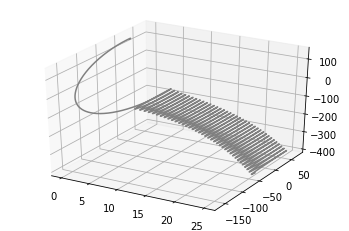

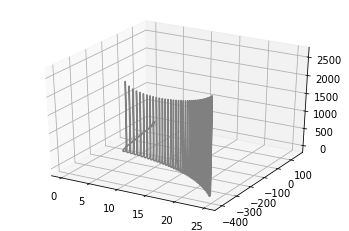

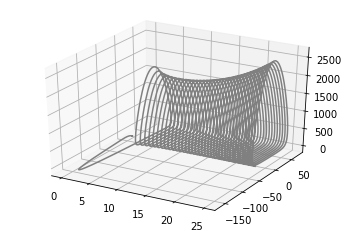

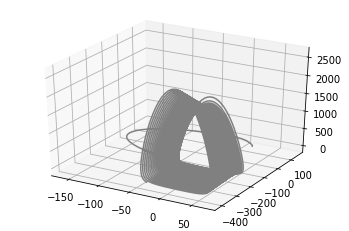

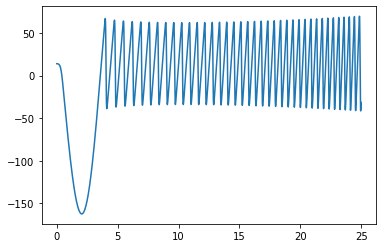

In [ ]:
import matplotlib.pyplot as plt

ax = plt.axes(projection='3d')
ax.plot3D(tspan, solution[:,0], solution[:,1], 'gray')
plt.show()

ax = plt.axes(projection='3d')
ax.plot3D(tspan, solution[:,1], solution[:,2], 'gray')
plt.show()

ax = plt.axes(projection='3d')
ax.plot3D(tspan, solution[:,0], solution[:,2], 'gray')
plt.show()

ax3 = plt.axes(projection='3d')
ax3.plot3D(solution[:,0], solution[:,1], solution[:,2], 'gray')
plt.show()


plt.plot(tspan,solution[:,0])
plt.show()

5. The system is chaotic we can see below the lyapunov expoenent of the system is around 0.05. The system grows exponetially we can see from the semi log plot and around 55 or 60 timeunits in becomes chaotic 

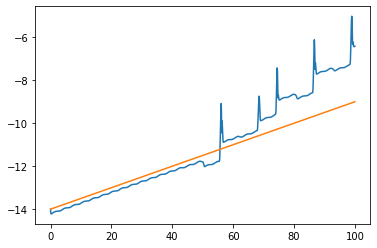

In [65]:
from scipy.integrate import odeint

#Pick points that are not equilibruim point
xvec = np.array([1,1,1])
delta0 = 1.0e-6

xvec2 = xvec+ (3**(1/3))/3*delta0*np.array([1,1,1])
tspan = np.linspace(0,100,10000)

solution = odeint(System,xvec,tspan,rtol=1.0e-13,atol=1.0e-12)
solution2 = odeint(System,xvec2,tspan,rtol=1.0e-13,atol=1.0e-12)

delta1a = solution2-solution
delta1 = []

for i in range(0,len(delta1a)):
  delta1.append(np.sqrt(np.sum(delta1a[i]*delta1a[i])))
delta1 = np.array(delta1)

lam = 0.05
plt.plot(tspan,np.log(delta1))
plt.plot(tspan,tspan*lam-14)
plt.show()